# 승리 전략 도출을 위한 상세 데이터 분석

<목차>

1. 개요

2. EDA

3. 데이터 분석

4. 분석 결론

---
---

## 개요

### 1. 목적
- 승리에 주요하게 영향을 미치는 특성과 내 경기의 특성을 비교 분석하여 <월드클래스>로 승급하기 위한 FC온라인 경기 승리 전략을 수립한다.

### 2. 데이터 설명
1. FC온라인 API를 통해 수집한 다른 유저들의 경기 데이터
    - 득점한 선수에 관련한 데이터는 분석에 활용하지 않고, 유저의 플레이 데이터만 활용한다.
    - 매치ID별, 유저별 경기 기록 데이터

2. 머신러닝에 활용한 데이터
    - 전처리 완료한 유저별 경기 기록 데이터

3. 최종 모델의 주요 변수
    - 스루패스 성공, 시도
    - 짧은 패스 성공, 시도
    - 유효슛
    - 롱패스 성공
    - 블록성공
    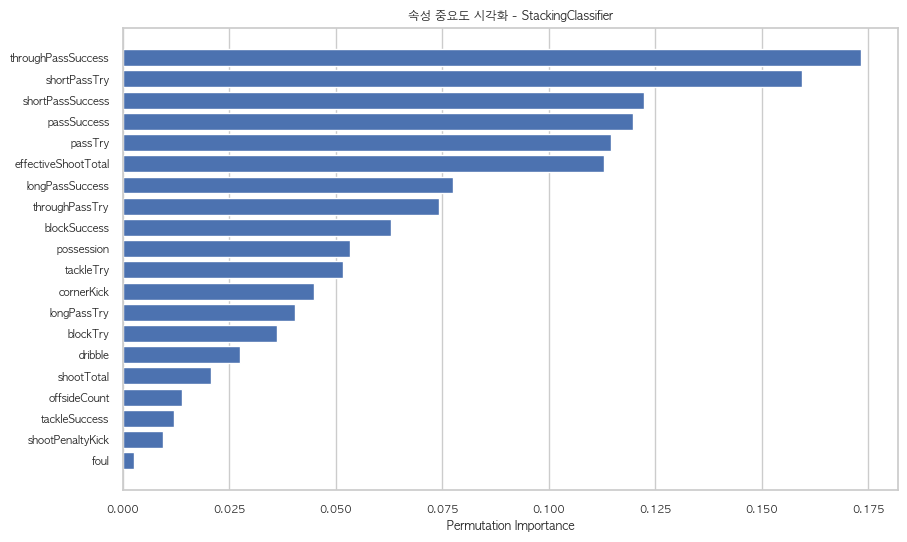

### 3. 분석 환경 조성

#### ㄴ 라이브러리 호출

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ 한글 폰트 설정하기
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] =False

#### ㄴ 데이터 호출

In [153]:
# 다른 유저 데이터
## 데이터 프레임 생성
match_df = pd.read_csv('./data/match_data.csv', encoding='utf-8-sig')
match_merge_df = pd.read_csv('./data/match_merge_data.csv', encoding='utf-8-sig')

## 데이터 크기 확인
print(match_df.shape)
print(match_merge_df.shape)

(4095, 43)
(579, 30)


In [154]:
# 내 데이터
## 데이터 프레임 생성
my_match_df = pd.read_csv('./data/my_match_data.csv', encoding='utf-8-sig')

## 데이터 크기 확인
print(my_match_df.shape)

(452, 43)


In [155]:
# 데이터 프레임별 head 확인 - 골 관련 세부 데이터 존재
match_df.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0.0,0.0,0.0,...,1545,0.936611,0.543738,2,3,827167198,True,825054050,False,True
1,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0.0,0.0,0.0,...,16777585,0.846402,0.387678,1,1,827167198,True,814200145,False,True
2,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0.0,0.0,0.0,...,16777916,0.818322,0.401577,2,2,827167198,True,814200145,False,False
3,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0.0,0.0,0.0,...,16779340,0.887430,0.428050,2,2,827167198,True,825054050,False,True
4,67e5abd6293b2e29d79b74f4,2025-03-27T19:59:51,50,78bd4904e360e8f15281c765ad9069e1,김진효,무,0,0.0,0.0,0.0,...,16779891,0.905626,0.629533,6,1,825054050,True,252020801,False,True


In [156]:
# 데이터 프레임별 head 확인 - 매치별 유저아이디별 데이터(시계열 데이터 존재)
match_merge_df.head()

,matchId,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,...,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchDate,matchResult
0,67e5ab6c26956677381da20f,00bb68e0fa9a9f7cb1665b32dd8069b7,1.0,0.0,0.0,0.0,64.0,3.0,0.0,3.0,...,16.0,16.0,17.0,9.0,5.0,1.0,44.0,3.63333,2025-03-27T19:59:05,패
1,67e5ab6c26956677381da20f,b732daf0b96fc9256262fb36cb72c1bc,0.0,0.0,0.0,0.0,75.0,1.0,1.0,14.0,...,26.0,25.0,13.0,8.0,5.0,0.0,56.0,4.59444,2025-03-27T19:59:05,승
2,67e5ab6d0b020281e49f1496,7fe7ffb96f2154e14825d674841ff270,0.0,0.0,0.0,0.0,80.0,2.0,0.0,7.0,...,19.0,17.0,6.0,4.0,8.0,1.0,58.0,4.21667,2025-03-27T19:58:36,승
3,67e5ab6d0b020281e49f1496,a184d3be0a42e0978644eb62b3b41ff5,1.0,0.0,0.0,0.0,68.0,1.0,0.0,8.0,...,22.0,18.0,21.0,9.0,6.0,0.0,42.0,3.82778,2025-03-27T19:58:36,패
4,67e5ab6edc4cb4e86e4f9236,eb36555d4d460edc57ee20b782723388,0.0,0.0,0.0,0.0,72.0,0.0,1.0,6.0,...,15.0,13.0,4.0,1.0,15.0,2.0,44.0,4.07222,2025-03-27T19:59:02,패


In [157]:
# 데이터 프레임별 head 확인 - 내 경기 데이터
my_match_df.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67f28b462eb651db4744652d,2025-04-06T14:22:04,50,411120587ad0909388fc1aee3961efb9,역대급재능유태상,무,0,3.0,0.0,1.0,...,16779176,0.943803,0.428774,2,1,829212478,False,-1,False,True
1,67f28b462eb651db4744652d,2025-04-06T14:22:04,50,411120587ad0909388fc1aee3961efb9,역대급재능유태상,무,0,3.0,0.0,1.0,...,16778666,0.855173,0.483792,4,2,829212478,True,829237496,False,True
2,67f28b462eb651db4744652d,2025-04-06T14:22:04,50,411120587ad0909388fc1aee3961efb9,역대급재능유태상,무,0,3.0,0.0,1.0,...,755,0.881091,0.510954,3,1,832227796,False,-1,False,True
3,67f28b462eb651db4744652d,2025-04-06T14:22:04,50,411120587ad0909388fc1aee3961efb9,역대급재능유태상,무,0,3.0,0.0,1.0,...,1575,0.754304,0.408483,12,1,829007743,True,826238744,False,False
4,67f28b462eb651db4744652d,2025-04-06T14:22:04,50,411120587ad0909388fc1aee3961efb9,역대급재능유태상,무,0,3.0,0.0,1.0,...,16777462,0.803299,0.530606,8,3,829237496,False,-1,False,False


---

## 데이터 전처리

### 1) 다른 유저 데이터
- 머신러닝 모델 과정에서 어느정도 전처리 완료(골 데이터 분리, 매치별 유저별 데이터로 그룹핑 등)

#### ㄴ 데이터 확인

In [158]:
# 데이터 크기 확인
match_merge_df.shape

(579, 30)

In [159]:
# 매치별 데이터 확인
match_merge_df.head(3)

,matchId,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,...,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchDate,matchResult
0,67e5ab6c26956677381da20f,00bb68e0fa9a9f7cb1665b32dd8069b7,1.0,0.0,0.0,0.0,64.0,3.0,0.0,3.0,...,16.0,16.0,17.0,9.0,5.0,1.0,44.0,3.63333,2025-03-27T19:59:05,패
1,67e5ab6c26956677381da20f,b732daf0b96fc9256262fb36cb72c1bc,0.0,0.0,0.0,0.0,75.0,1.0,1.0,14.0,...,26.0,25.0,13.0,8.0,5.0,0.0,56.0,4.59444,2025-03-27T19:59:05,승
2,67e5ab6d0b020281e49f1496,7fe7ffb96f2154e14825d674841ff270,0.0,0.0,0.0,0.0,80.0,2.0,0.0,7.0,...,19.0,17.0,6.0,4.0,8.0,1.0,58.0,4.21667,2025-03-27T19:58:36,승


In [160]:
# 데이터 크기 확인
match_merge_df.describe(include='all')

,matchId,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,...,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchDate,matchResult
count,579,579,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,...,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579,579
unique,317,572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,279,3
top,67e5ab6c26956677381da20f,00bb68e0fa9a9f7cb1665b32dd8069b7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-04-03T22:59:38,승
freq,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,233
mean,NaN,NaN,0.637306,0.103627,0.005181,0.079447,73.312608,1.791019,0.630397,6.932642,...,21.146805,17.934370,11.202073,6.250432,8.440415,0.666667,50.005181,4.113280,NaN,NaN
std,NaN,NaN,0.831718,0.316180,0.071857,0.295132,14.179303,1.573853,0.818160,3.143173,...,10.077427,8.860267,5.705482,3.084364,3.598994,0.822128,5.708457,0.343265,NaN,NaN
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,38.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,30.000000,3.050000,NaN,NaN
25%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,64.000000,1.000000,0.000000,5.000000,...,14.000000,12.000000,7.000000,4.000000,6.000000,0.000000,47.000000,3.894440,NaN,NaN
50%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,72.000000,1.000000,0.000000,7.000000,...,20.000000,17.000000,11.000000,6.000000,8.000000,0.000000,50.000000,4.127780,NaN,NaN
75%,NaN,NaN,1.000000,0.000000,0.000000,0.000000,82.000000,3.000000,1.000000,9.000000,...,27.000000,23.000000,15.000000,8.000000,10.000000,1.000000,53.000000,4.327780,NaN,NaN


#### ㄴ 결측치, 중복값 확인

In [161]:
# 결측치 확인
match_merge_df.isna().sum()

matchId                0
ouid                   0
foul                   0
injury                 0
redCards               0
yellowCards            0
dribble                0
cornerKick             0
offsideCount           0
shootTotal             0
effectiveShootTotal    0
goalTotal              0
shootPenaltyKick       0
goalPenaltyKick        0
passTry                0
passSuccess            0
shortPassTry           0
shortPassSuccess       0
longPassTry            0
longPassSuccess        0
throughPassTry         0
throughPassSuccess     0
tackleTry              0
tackleSuccess          0
blockTry               0
blockSuccess           0
possession             0
averageRating          0
matchDate              0
matchResult            0
dtype: int64

In [162]:
# 중복값 확인
match_merge_df.duplicated().sum()

np.int64(0)

#### ㄴ 이상치 확인

In [163]:
try_success_cols = ['dribble', 'cornerKick','offsideCount','shootTotal','effectiveShootTotal','goalTotal', 'shortPassTry', 'shortPassSuccess', 'longPassTry', 'longPassSuccess' ,'throughPassTry','throughPassSuccess','tackleTry','tackleSuccess','blockTry','blockSuccess']

# 데이터 누수 방지를 위해 데이터프레임 복제
outlier_processed_df = match_merge_df.copy()

# KNN 모델을 사용하여 이웃 계산
knn = NearestNeighbors(n_neighbors=5)  # n_neighbors 값을 직접 설정

# 데이터로 학습
knn.fit(outlier_processed_df[try_success_cols])

# 각 샘플에 대해 가장 가까운 이웃까지의 거리 계산
distances, indices = knn.kneighbors(outlier_processed_df[try_success_cols])

# distance_threshold 값을 결정하는 방법 (상위 90% 거리값 기준)
distance_threshold = np.percentile(distances[:, -1], 90)

# 이상치 판별
outliers = distances[:, -1] > distance_threshold

# 이상치 대치 (예: 가까운 이웃의 평균값으로 대체)
for i in range(outlier_processed_df[try_success_cols].shape[0]):
    if outliers[i]:
        # 이상치인 경우, 해당 샘플의 이웃들의 평균값으로 대체
        outlier_processed_df[try_success_cols].iloc[i] = np.mean(outlier_processed_df[try_success_cols].iloc[indices[i]], axis=0)

# 결과 출력
print(f"감지된 이상치 개수: {sum(outliers)}")

감지된 이상치 개수: 58


#### ㄴ 데이터 인코딩

In [164]:
# 데이터 프레임 복제
encoded_df = outlier_processed_df.copy()
encoded_df.head()

,matchId,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,...,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchDate,matchResult
0,67e5ab6c26956677381da20f,00bb68e0fa9a9f7cb1665b32dd8069b7,1.0,0.0,0.0,0.0,64.0,3.0,0.0,3.0,...,16.0,16.0,17.0,9.0,5.0,1.0,44.0,3.63333,2025-03-27T19:59:05,패
1,67e5ab6c26956677381da20f,b732daf0b96fc9256262fb36cb72c1bc,0.0,0.0,0.0,0.0,75.0,1.0,1.0,14.0,...,26.0,25.0,13.0,8.0,5.0,0.0,56.0,4.59444,2025-03-27T19:59:05,승
2,67e5ab6d0b020281e49f1496,7fe7ffb96f2154e14825d674841ff270,0.0,0.0,0.0,0.0,80.0,2.0,0.0,7.0,...,19.0,17.0,6.0,4.0,8.0,1.0,58.0,4.21667,2025-03-27T19:58:36,승
3,67e5ab6d0b020281e49f1496,a184d3be0a42e0978644eb62b3b41ff5,1.0,0.0,0.0,0.0,68.0,1.0,0.0,8.0,...,22.0,18.0,21.0,9.0,6.0,0.0,42.0,3.82778,2025-03-27T19:58:36,패
4,67e5ab6edc4cb4e86e4f9236,eb36555d4d460edc57ee20b782723388,0.0,0.0,0.0,0.0,72.0,0.0,1.0,6.0,...,15.0,13.0,4.0,1.0,15.0,2.0,44.0,4.07222,2025-03-27T19:59:02,패


In [165]:
# datetime 형식으로 변환
encoded_df['matchDate'] = pd.to_datetime(encoded_df['matchDate'])

# 평일/주말
encoded_df['weekend'] = encoded_df['matchDate'].dt.weekday.map(lambda x: '평일' if x < 5 else '주말')

# 요일
encoded_df['weekday'] = encoded_df['matchDate'].dt.day_name()

# matchDate 삭제
encoded_df = encoded_df.drop(columns='matchDate')

# 데이터 확인
print(encoded_df.shape)
encoded_df.head()

(579, 31)


,matchId,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,...,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchResult,weekend,weekday
0,67e5ab6c26956677381da20f,00bb68e0fa9a9f7cb1665b32dd8069b7,1.0,0.0,0.0,0.0,64.0,3.0,0.0,3.0,...,16.0,17.0,9.0,5.0,1.0,44.0,3.63333,패,평일,Thursday
1,67e5ab6c26956677381da20f,b732daf0b96fc9256262fb36cb72c1bc,0.0,0.0,0.0,0.0,75.0,1.0,1.0,14.0,...,25.0,13.0,8.0,5.0,0.0,56.0,4.59444,승,평일,Thursday
2,67e5ab6d0b020281e49f1496,7fe7ffb96f2154e14825d674841ff270,0.0,0.0,0.0,0.0,80.0,2.0,0.0,7.0,...,17.0,6.0,4.0,8.0,1.0,58.0,4.21667,승,평일,Thursday
3,67e5ab6d0b020281e49f1496,a184d3be0a42e0978644eb62b3b41ff5,1.0,0.0,0.0,0.0,68.0,1.0,0.0,8.0,...,18.0,21.0,9.0,6.0,0.0,42.0,3.82778,패,평일,Thursday
4,67e5ab6edc4cb4e86e4f9236,eb36555d4d460edc57ee20b782723388,0.0,0.0,0.0,0.0,72.0,0.0,1.0,6.0,...,13.0,4.0,1.0,15.0,2.0,44.0,4.07222,패,평일,Thursday


### 2) 내 데이터

#### ㄴ 데이터 확인

In [166]:
# 데이터 크기 확인
my_match_df.shape

(452, 43)

In [167]:
# 기술 통계 분석
my_match_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
matchId,452,31,67dfd655a90c32a27f4a1e0f,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchDate,452,31,2025-03-23T09:40:18,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchType,452.0,NaN,NaN,NaN,50.0,0.0,50.0,50.0,50.0,50.0,50.0
ouid,452,31,56f931578b228109e8e44599da41ea64,214,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nickname,452,31,Ithas,214,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchResult,452,3,승,198,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchEndType,452.0,NaN,NaN,NaN,0.050885,0.220006,0.0,0.0,0.0,0.0,1.0
foul,421.0,NaN,NaN,NaN,0.75772,0.874626,0.0,0.0,1.0,1.0,3.0
injury,421.0,NaN,NaN,NaN,0.171021,0.376976,0.0,0.0,0.0,0.0,1.0
redCards,421.0,NaN,NaN,NaN,0.08076,0.272791,0.0,0.0,0.0,0.0,1.0


In [168]:
# 데이터 정보 확인
my_match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   matchId              452 non-null    object 
 1   matchDate            452 non-null    object 
 2   matchType            452 non-null    int64  
 3   ouid                 452 non-null    object 
 4   nickname             452 non-null    object 
 5   matchResult          452 non-null    object 
 6   matchEndType         452 non-null    int64  
 7   foul                 421 non-null    float64
 8   injury               421 non-null    float64
 9   redCards             421 non-null    float64
 10  yellowCards          421 non-null    float64
 11  possession           421 non-null    float64
 12  averageRating        421 non-null    float64
 13  dribble              421 non-null    float64
 14  cornerKick           421 non-null    float64
 15  offsideCount         421 non-null    flo

#### ㄴ 데이터 분포 시각화

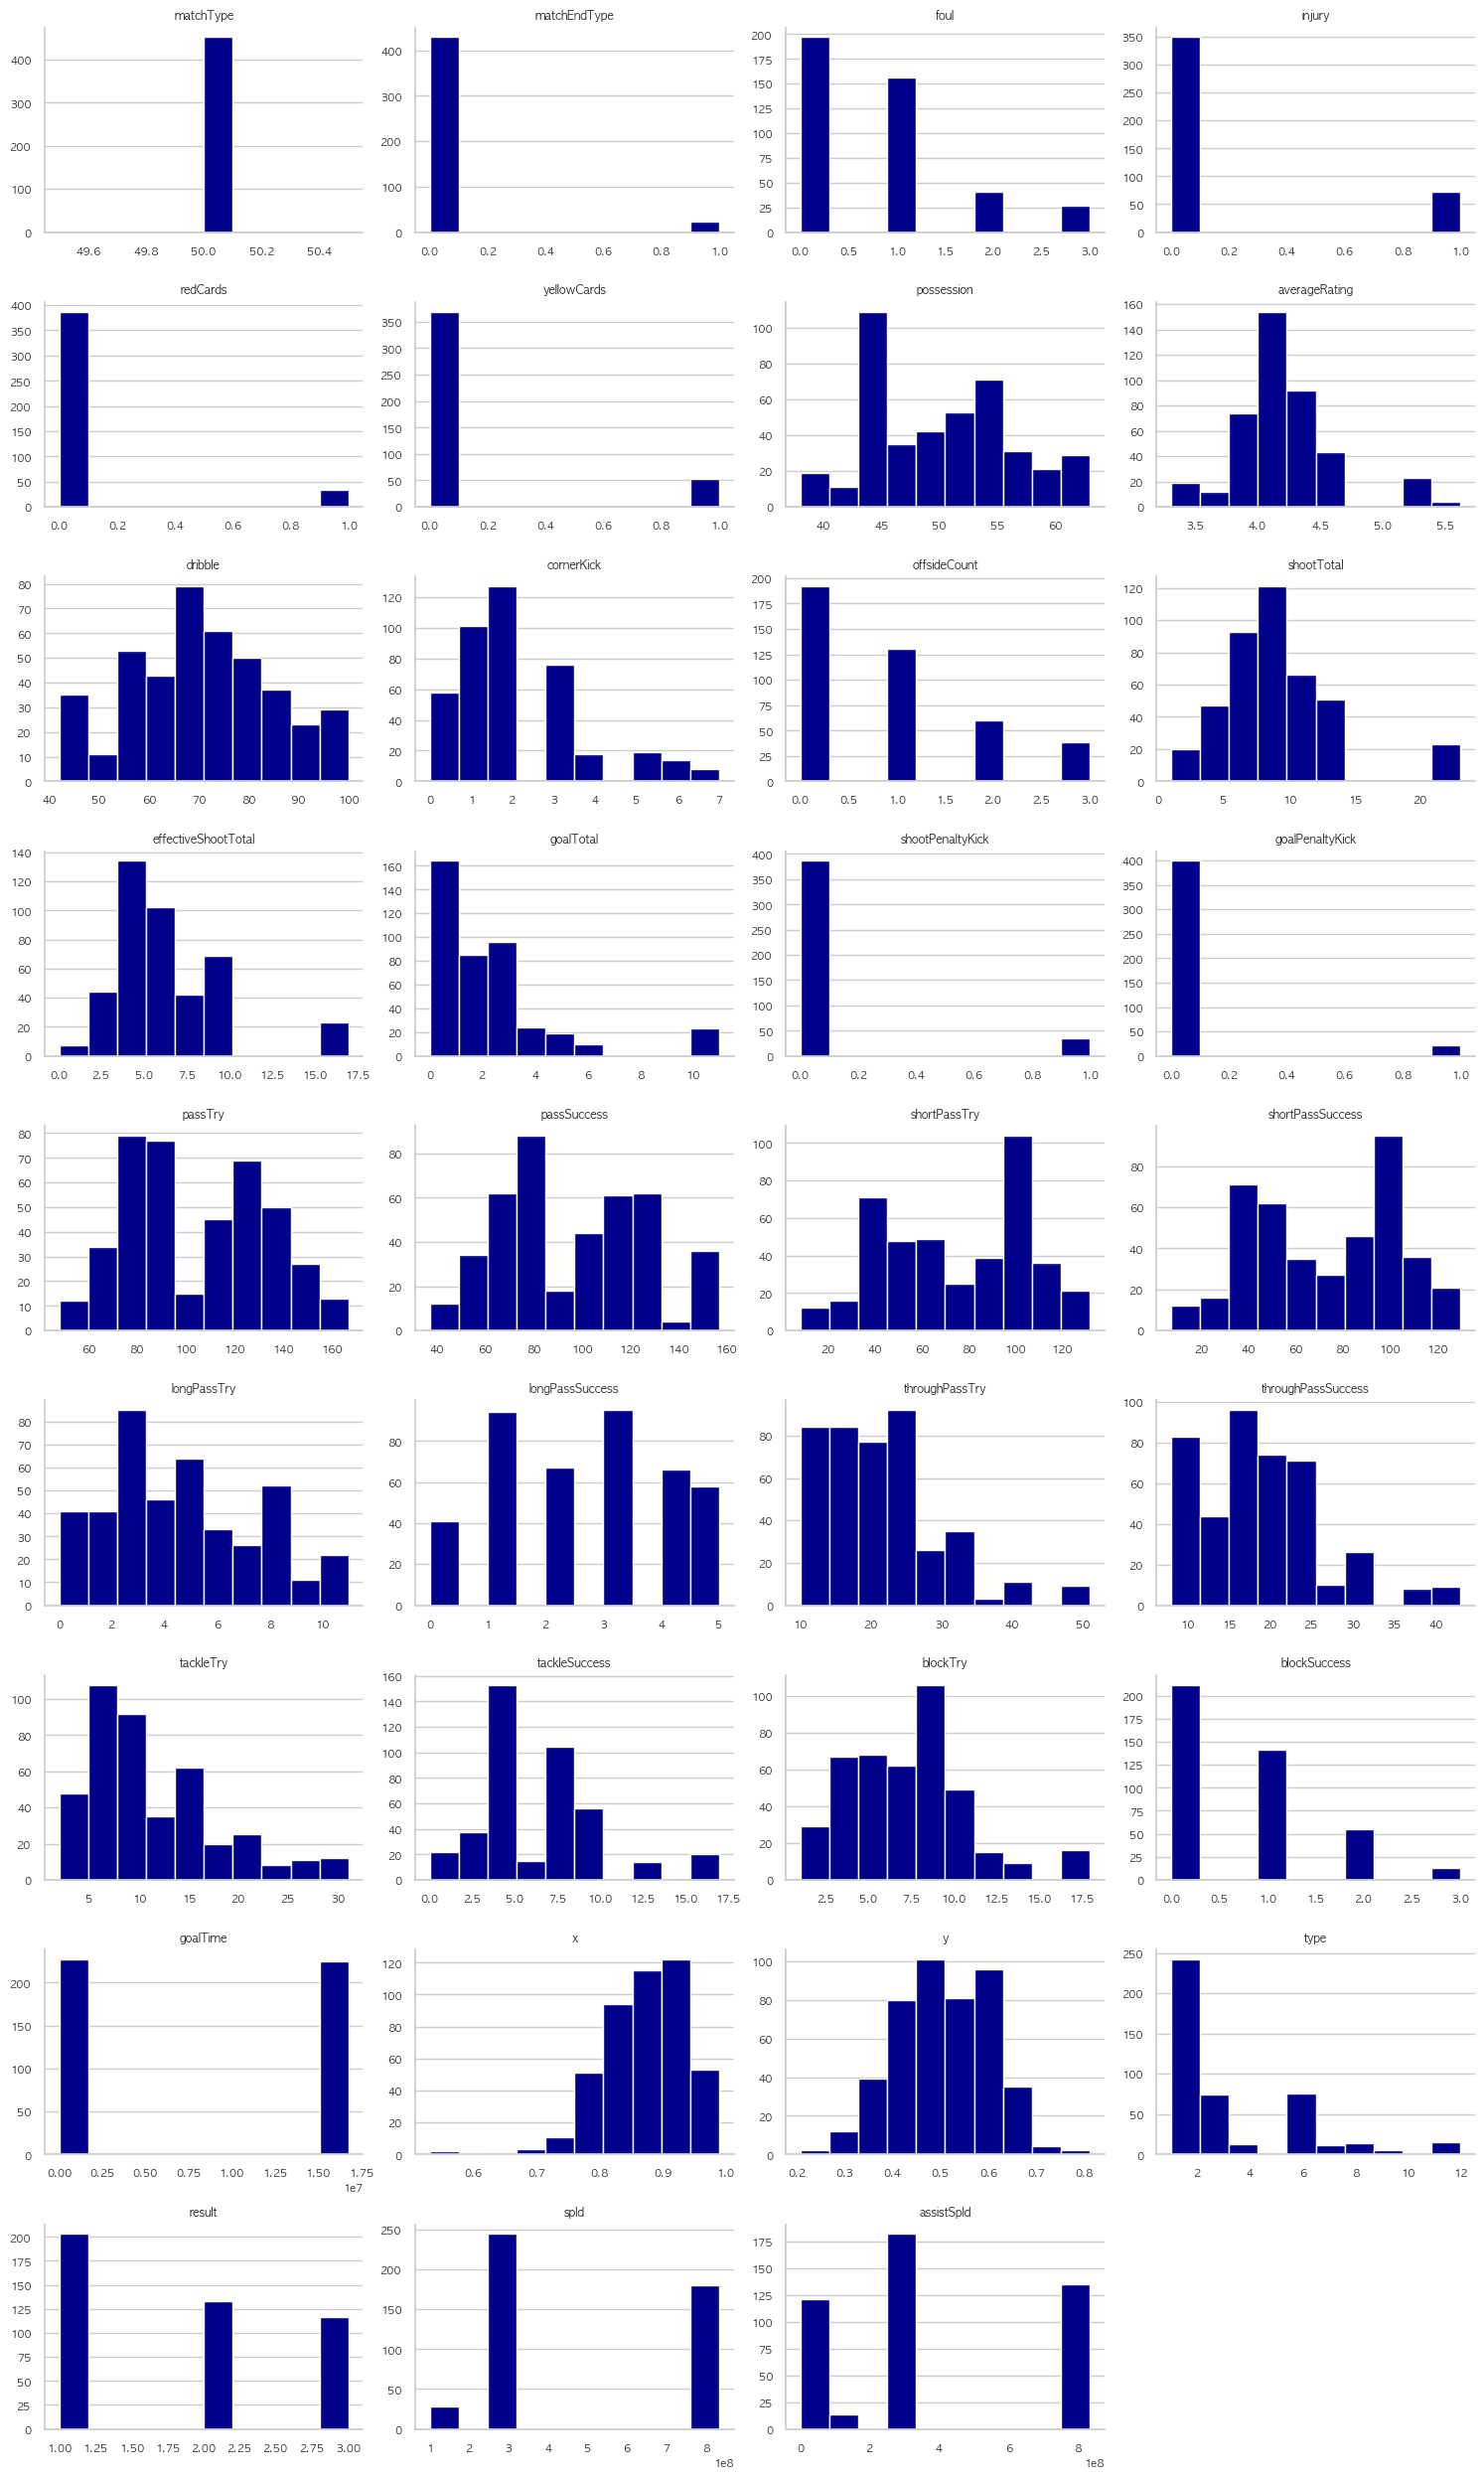

In [169]:
# 데이터 분포 시각화
# 변수 선별
numeric_df = my_match_df.select_dtypes(include=['number'])
cols = numeric_df.columns

# 서브플롯 생성
fig, axes = plt.subplots(9, 4, figsize=(15, 25))
axes = axes.flatten()

# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    axes[i].hist(numeric_df[column].dropna(), color='darkblue', alpha=1)
    axes[i].set_title(column)
    axes[i].grid(axis='x', linestyle=':', color='darkgrey')
    axes[i].grid(axis='x')
    axes[i].spines[['top','right']].set_visible(False)

# 빈 서브플롯 숨기기
for j in range(len(cols), len(axes)):
    axes[j].axis("off")

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

> 결론
- matchEndType = 0 (정상종료) 데이터만 남겨야 한다.
- 골 관련 세부 데이터는 분리해야한다.

#### ㄴ 데이터 제외
- 몰수패, 몰수승, 다른 유저 데이터 제외
- 슛 관련 세부 데이터 및 닉네임 제외

In [170]:
# 몰수패, 몰수승 제외
my_match_df = my_match_df[my_match_df['matchEndType'] == 0]
my_match_df['matchEndType'].unique()

array([0])

In [171]:
# 내 경기만 남기고 제거
my_match_df = my_match_df[my_match_df['nickname'] == 'Ithas']
my_match_df['nickname'].unique()

array(['Ithas'], dtype=object)

In [172]:
# 슛 관련 세부 데이터, 닉네임 제외
no_goal_df = my_match_df.copy()
no_goal_df = no_goal_df.drop(columns=['nickname','goalTime','x','y','type','result','spId','assist','assistSpId','hitPost','inPenalty'])
no_goal_df.columns

Index(['matchId', 'matchDate', 'matchType', 'ouid', 'matchResult',
       'matchEndType', 'foul', 'injury', 'redCards', 'yellowCards',
       'possession', 'averageRating', 'dribble', 'cornerKick', 'offsideCount',
       'shootTotal', 'effectiveShootTotal', 'goalTotal', 'shootPenaltyKick',
       'goalPenaltyKick', 'passTry', 'passSuccess', 'shortPassTry',
       'shortPassSuccess', 'longPassTry', 'longPassSuccess', 'throughPassTry',
       'throughPassSuccess', 'tackleTry', 'tackleSuccess', 'blockTry',
       'blockSuccess'],
      dtype='object')

In [173]:
no_goal_df.head()

,matchId,matchDate,matchType,ouid,matchResult,matchEndType,foul,injury,redCards,yellowCards,...,shortPassTry,shortPassSuccess,longPassTry,longPassSuccess,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess
7,67f28b462eb651db4744652d,2025-04-06T14:22:04,50,56f931578b228109e8e44599da41ea64,무,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,67f28b462eb651db4744652d,2025-04-06T14:22:04,50,56f931578b228109e8e44599da41ea64,무,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,67f28b462eb651db4744652d,2025-04-06T14:22:04,50,56f931578b228109e8e44599da41ea64,무,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,67f28b462eb651db4744652d,2025-04-06T14:22:04,50,56f931578b228109e8e44599da41ea64,무,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,67f28b462eb651db4744652d,2025-04-06T14:22:04,50,56f931578b228109e8e44599da41ea64,무,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### ㄴ 결측값, 중복값 처리 확인

In [174]:
# 결측값 확인
no_goal_df.isna().sum()

matchId                 0
matchDate               0
matchType               0
ouid                    0
matchResult             0
matchEndType            0
foul                   19
injury                 19
redCards               19
yellowCards            19
possession             19
averageRating          19
dribble                19
cornerKick             19
offsideCount           19
shootTotal             19
effectiveShootTotal    19
goalTotal              19
shootPenaltyKick       19
goalPenaltyKick        19
passTry                19
passSuccess            19
shortPassTry           19
shortPassSuccess       19
longPassTry            19
longPassSuccess        19
throughPassTry         19
throughPassSuccess     19
tackleTry              19
tackleSuccess          19
blockTry               19
blockSuccess           19
dtype: int64

In [175]:
# 결측치 확인
no_goal_df[no_goal_df.isna().any(axis=1)].head(3).T

,7,8,9
matchId,67f28b462eb651db4744652d,67f28b462eb651db4744652d,67f28b462eb651db4744652d
matchDate,2025-04-06T14:22:04,2025-04-06T14:22:04,2025-04-06T14:22:04
matchType,50,50,50
ouid,56f931578b228109e8e44599da41ea64,56f931578b228109e8e44599da41ea64,56f931578b228109e8e44599da41ea64
matchResult,무,무,무
matchEndType,0,0,0
foul,NaN,NaN,NaN
injury,NaN,NaN,NaN
redCards,NaN,NaN,NaN
yellowCards,NaN,NaN,NaN


데이터 집계오류로 판단하여 삭제

In [176]:
# 결측치 삭제
preprocessed_df = no_goal_df.dropna(axis=0)
preprocessed_df.isna().sum()

matchId                0
matchDate              0
matchType              0
ouid                   0
matchResult            0
matchEndType           0
foul                   0
injury                 0
redCards               0
yellowCards            0
possession             0
averageRating          0
dribble                0
cornerKick             0
offsideCount           0
shootTotal             0
effectiveShootTotal    0
goalTotal              0
shootPenaltyKick       0
goalPenaltyKick        0
passTry                0
passSuccess            0
shortPassTry           0
shortPassSuccess       0
longPassTry            0
longPassSuccess        0
throughPassTry         0
throughPassSuccess     0
tackleTry              0
tackleSuccess          0
blockTry               0
blockSuccess           0
dtype: int64

#### ㄴ 중복값 처리

- 데이터는 골 기준으로 ROW가 생성되고 있다.
- 한 경기에 여러 골이 발생하므로 matchId는 중복값 발생
- 따라서 식별자로 사용할 수 없으므로 모든 행에 대해서 중복값이 있는지 체크한다.

In [177]:
# 중복값 확인
preprocessed_df.duplicated().sum()

np.int64(144)

In [178]:
# 중복 데이터 확인
preprocessed_df[preprocessed_df.duplicated()].head()

,matchId,matchDate,matchType,ouid,matchResult,matchEndType,foul,injury,redCards,yellowCards,...,shortPassTry,shortPassSuccess,longPassTry,longPassSuccess,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess
24,67f288c8c762f5782a9565b0,2025-04-06T14:09:49,50,56f931578b228109e8e44599da41ea64,승,0,2.0,0.0,0.0,0.0,...,105.0,99.0,7.0,5.0,18.0,16.0,12.0,8.0,10.0,2.0
25,67f288c8c762f5782a9565b0,2025-04-06T14:09:49,50,56f931578b228109e8e44599da41ea64,승,0,2.0,0.0,0.0,0.0,...,105.0,99.0,7.0,5.0,18.0,16.0,12.0,8.0,10.0,2.0
26,67f288c8c762f5782a9565b0,2025-04-06T14:09:49,50,56f931578b228109e8e44599da41ea64,승,0,2.0,0.0,0.0,0.0,...,105.0,99.0,7.0,5.0,18.0,16.0,12.0,8.0,10.0,2.0
27,67f288c8c762f5782a9565b0,2025-04-06T14:09:49,50,56f931578b228109e8e44599da41ea64,승,0,2.0,0.0,0.0,0.0,...,105.0,99.0,7.0,5.0,18.0,16.0,12.0,8.0,10.0,2.0
38,67f285c2487ac8490477e386,2025-04-06T13:57:14,50,56f931578b228109e8e44599da41ea64,패,0,1.0,0.0,0.0,0.0,...,105.0,99.0,3.0,1.0,26.0,22.0,14.0,8.0,7.0,1.0


In [179]:
# 첫번째 데이터만 남기고 제거
preprocessed_df = preprocessed_df.drop_duplicates(keep='first')
preprocessed_df.duplicated().sum()

np.int64(0)

In [180]:
preprocessed_df

,matchId,matchDate,matchType,ouid,matchResult,matchEndType,foul,injury,redCards,yellowCards,...,shortPassTry,shortPassSuccess,longPassTry,longPassSuccess,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess
23,67f288c8c762f5782a9565b0,2025-04-06T14:09:49,50,56f931578b228109e8e44599da41ea64,승,0,2.0,0.0,0.0,0.0,...,105.0,99.0,7.0,5.0,18.0,16.0,12.0,8.0,10.0,2.0
37,67f285c2487ac8490477e386,2025-04-06T13:57:14,50,56f931578b228109e8e44599da41ea64,패,0,1.0,0.0,0.0,0.0,...,105.0,99.0,3.0,1.0,26.0,22.0,14.0,8.0,7.0,1.0
42,67f28323527a5d6ef3d0f933,2025-04-06T13:46:11,50,56f931578b228109e8e44599da41ea64,무,0,2.0,0.0,0.0,0.0,...,91.0,88.0,2.0,1.0,21.0,16.0,7.0,3.0,8.0,0.0
65,67f121739c2e022ac3ad4606,2025-04-05T12:36:40,50,56f931578b228109e8e44599da41ea64,무,0,1.0,0.0,0.0,0.0,...,102.0,100.0,5.0,3.0,17.0,15.0,5.0,4.0,13.0,2.0
94,67ed4e529456ae84ed9ea8ba,2025-04-02T14:58:41,50,56f931578b228109e8e44599da41ea64,무,0,1.0,0.0,0.0,0.0,...,93.0,90.0,4.0,1.0,23.0,18.0,6.0,5.0,12.0,2.0
98,67ea978928f42b3e871c6696,2025-03-31T13:34:35,50,56f931578b228109e8e44599da41ea64,승,0,0.0,1.0,0.0,0.0,...,110.0,108.0,6.0,3.0,20.0,17.0,4.0,3.0,6.0,1.0
112,67ea94edd6c13d20aa55c0de,2025-03-31T13:24:08,50,56f931578b228109e8e44599da41ea64,패,0,0.0,0.0,0.0,0.0,...,97.0,95.0,2.0,1.0,25.0,22.0,12.0,8.0,10.0,2.0
123,67ea925c8a18ae10ecdf6870,2025-03-31T13:12:56,50,56f931578b228109e8e44599da41ea64,패,0,0.0,0.0,0.0,0.0,...,107.0,101.0,3.0,1.0,23.0,20.0,5.0,4.0,12.0,2.0
145,67e956fc9abf2e0d07ba485b,2025-03-30T14:46:56,50,56f931578b228109e8e44599da41ea64,패,0,1.0,0.0,0.0,0.0,...,101.0,94.0,8.0,5.0,12.0,12.0,10.0,8.0,6.0,0.0
157,67e67b5fd3f3a361664f605c,2025-03-28T10:46:07,50,56f931578b228109e8e44599da41ea64,무,0,1.0,0.0,0.0,0.0,...,86.0,82.0,3.0,3.0,19.0,15.0,7.0,4.0,3.0,0.0


- 득점과 관련된 데이터(득점 슛 위치 좌표, 슛 유형, 득점 시간, 득점 선수, 어시스트 선수)는 모델 생성에 활용하지 않고, 따로 세부 분석을 통해 인사이트를 도출하기로 한다.
    - ROW를 경기 단위로 생성하기 위함

In [181]:
# 몰수승, 몰수패는 정상적으로 종료되지 않은 매치이므로 제외한다.('matchEndType' == 0인 경우가 정상)
print(preprocessed_df['matchEndType'].unique())
preprocessed_df['matchEndType'].value_counts()

[0]


matchEndType
0    28
Name: count, dtype: int64

In [ ]:
# 평균으로 산출해야하는 변수들
match_group_mean_df = preprocessed_df.groupby(['matchId','ouid'])[[
        'foul', 'injury', 'redCards', 'yellowCards','dribble', 'cornerKick', 'offsideCount',
       'shootTotal', 'effectiveShootTotal', 'goalTotal', 'shootPenaltyKick',
       'goalPenaltyKick', 'passTry', 'passSuccess', 'shortPassTry',
       'shortPassSuccess', 'longPassTry', 'longPassSuccess', 'throughPassTry',
       'throughPassSuccess', 'tackleTry', 'tackleSuccess', 'blockTry', 'blockSuccess','possession', 'averageRating']].mean()
match_group_mean_df = match_group_mean_df.reset_index()

print(match_group_mean_df.shape)
match_group_mean_df.head()

(28, 28)


,matchId,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,...,longPassTry,longPassSuccess,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating
0,67dd625e1c27c154b533a0aa,56f931578b228109e8e44599da41ea64,1.0,0.0,0.0,1.0,82.0,2.0,0.0,9.0,...,8.0,5.0,18.0,16.0,3.0,1.0,11.0,2.0,57.0,4.20556
1,67dd650053e5e88154781b92,56f931578b228109e8e44599da41ea64,3.0,1.0,0.0,1.0,71.0,3.0,1.0,5.0,...,5.0,3.0,13.0,12.0,10.0,8.0,10.0,3.0,48.0,3.99444
2,67dd67a24be0a1e397cec6dd,56f931578b228109e8e44599da41ea64,1.0,0.0,0.0,0.0,81.0,4.0,0.0,7.0,...,6.0,5.0,16.0,14.0,5.0,4.0,9.0,1.0,55.0,4.15000
3,67dd6a476fb2bd6b95c4b63d,56f931578b228109e8e44599da41ea64,2.0,0.0,0.0,0.0,81.0,0.0,1.0,2.0,...,2.0,1.0,15.0,12.0,10.0,8.0,10.0,1.0,56.0,3.64444
4,67dd6cc0632b415e80a9d58d,56f931578b228109e8e44599da41ea64,0.0,0.0,0.0,0.0,88.0,0.0,2.0,6.0,...,5.0,2.0,13.0,12.0,6.0,5.0,8.0,0.0,57.0,4.11667


In [ ]:
# matchDate와 matchResult 결과 컬럼
date_result_tmp_df = preprocessed_df.drop_duplicates(subset=['matchId','ouid'],keep='last')
date_result_tmp_df = date_result_tmp_df[['matchId','ouid', 'matchDate','matchResult']]
date_result_tmp_df.head()

,matchId,ouid,matchDate,matchResult
23,67f288c8c762f5782a9565b0,56f931578b228109e8e44599da41ea64,2025-04-06T14:09:49,승
37,67f285c2487ac8490477e386,56f931578b228109e8e44599da41ea64,2025-04-06T13:57:14,패
42,67f28323527a5d6ef3d0f933,56f931578b228109e8e44599da41ea64,2025-04-06T13:46:11,무
65,67f121739c2e022ac3ad4606,56f931578b228109e8e44599da41ea64,2025-04-05T12:36:40,무
94,67ed4e529456ae84ed9ea8ba,56f931578b228109e8e44599da41ea64,2025-04-02T14:58:41,무
98,67ea978928f42b3e871c6696,56f931578b228109e8e44599da41ea64,2025-03-31T13:34:35,승
112,67ea94edd6c13d20aa55c0de,56f931578b228109e8e44599da41ea64,2025-03-31T13:24:08,패
123,67ea925c8a18ae10ecdf6870,56f931578b228109e8e44599da41ea64,2025-03-31T13:12:56,패
145,67e956fc9abf2e0d07ba485b,56f931578b228109e8e44599da41ea64,2025-03-30T14:46:56,패
157,67e67b5fd3f3a361664f605c,56f931578b228109e8e44599da41ea64,2025-03-28T10:46:07,무


- matchDate, matchResult 병합

In [184]:
# 최종 데이터 생성
match_merge_df = pd.merge(match_group_mean_df, date_result_tmp_df, how='inner', on=['matchId','ouid'])
print(match_merge_df.shape)
match_merge_df.head()

(28, 30)


,matchId,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,...,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchDate,matchResult
0,67dd625e1c27c154b533a0aa,56f931578b228109e8e44599da41ea64,1.0,0.0,0.0,1.0,82.0,2.0,0.0,9.0,...,18.0,16.0,3.0,1.0,11.0,2.0,57.0,4.20556,2025-03-21T13:08:27,무
1,67dd650053e5e88154781b92,56f931578b228109e8e44599da41ea64,3.0,1.0,0.0,1.0,71.0,3.0,1.0,5.0,...,13.0,12.0,10.0,8.0,10.0,3.0,48.0,3.99444,2025-03-21T13:20:15,패
2,67dd67a24be0a1e397cec6dd,56f931578b228109e8e44599da41ea64,1.0,0.0,0.0,0.0,81.0,4.0,0.0,7.0,...,16.0,14.0,5.0,4.0,9.0,1.0,55.0,4.15000,2025-03-21T13:31:18,무
3,67dd6a476fb2bd6b95c4b63d,56f931578b228109e8e44599da41ea64,2.0,0.0,0.0,0.0,81.0,0.0,1.0,2.0,...,15.0,12.0,10.0,8.0,10.0,1.0,56.0,3.64444,2025-03-21T13:41:54,패
4,67dd6cc0632b415e80a9d58d,56f931578b228109e8e44599da41ea64,0.0,0.0,0.0,0.0,88.0,0.0,2.0,6.0,...,13.0,12.0,6.0,5.0,8.0,0.0,57.0,4.11667,2025-03-21T13:52:50,무


#### ㄴ 이상치 처리

In [185]:
# 숫자형 변수
numeric_cols = match_merge_df.select_dtypes('number').columns
numeric_cols

Index(['foul', 'injury', 'redCards', 'yellowCards', 'dribble', 'cornerKick',
       'offsideCount', 'shootTotal', 'effectiveShootTotal', 'goalTotal',
       'shootPenaltyKick', 'goalPenaltyKick', 'passTry', 'passSuccess',
       'shortPassTry', 'shortPassSuccess', 'longPassTry', 'longPassSuccess',
       'throughPassTry', 'throughPassSuccess', 'tackleTry', 'tackleSuccess',
       'blockTry', 'blockSuccess', 'possession', 'averageRating'],
      dtype='object')

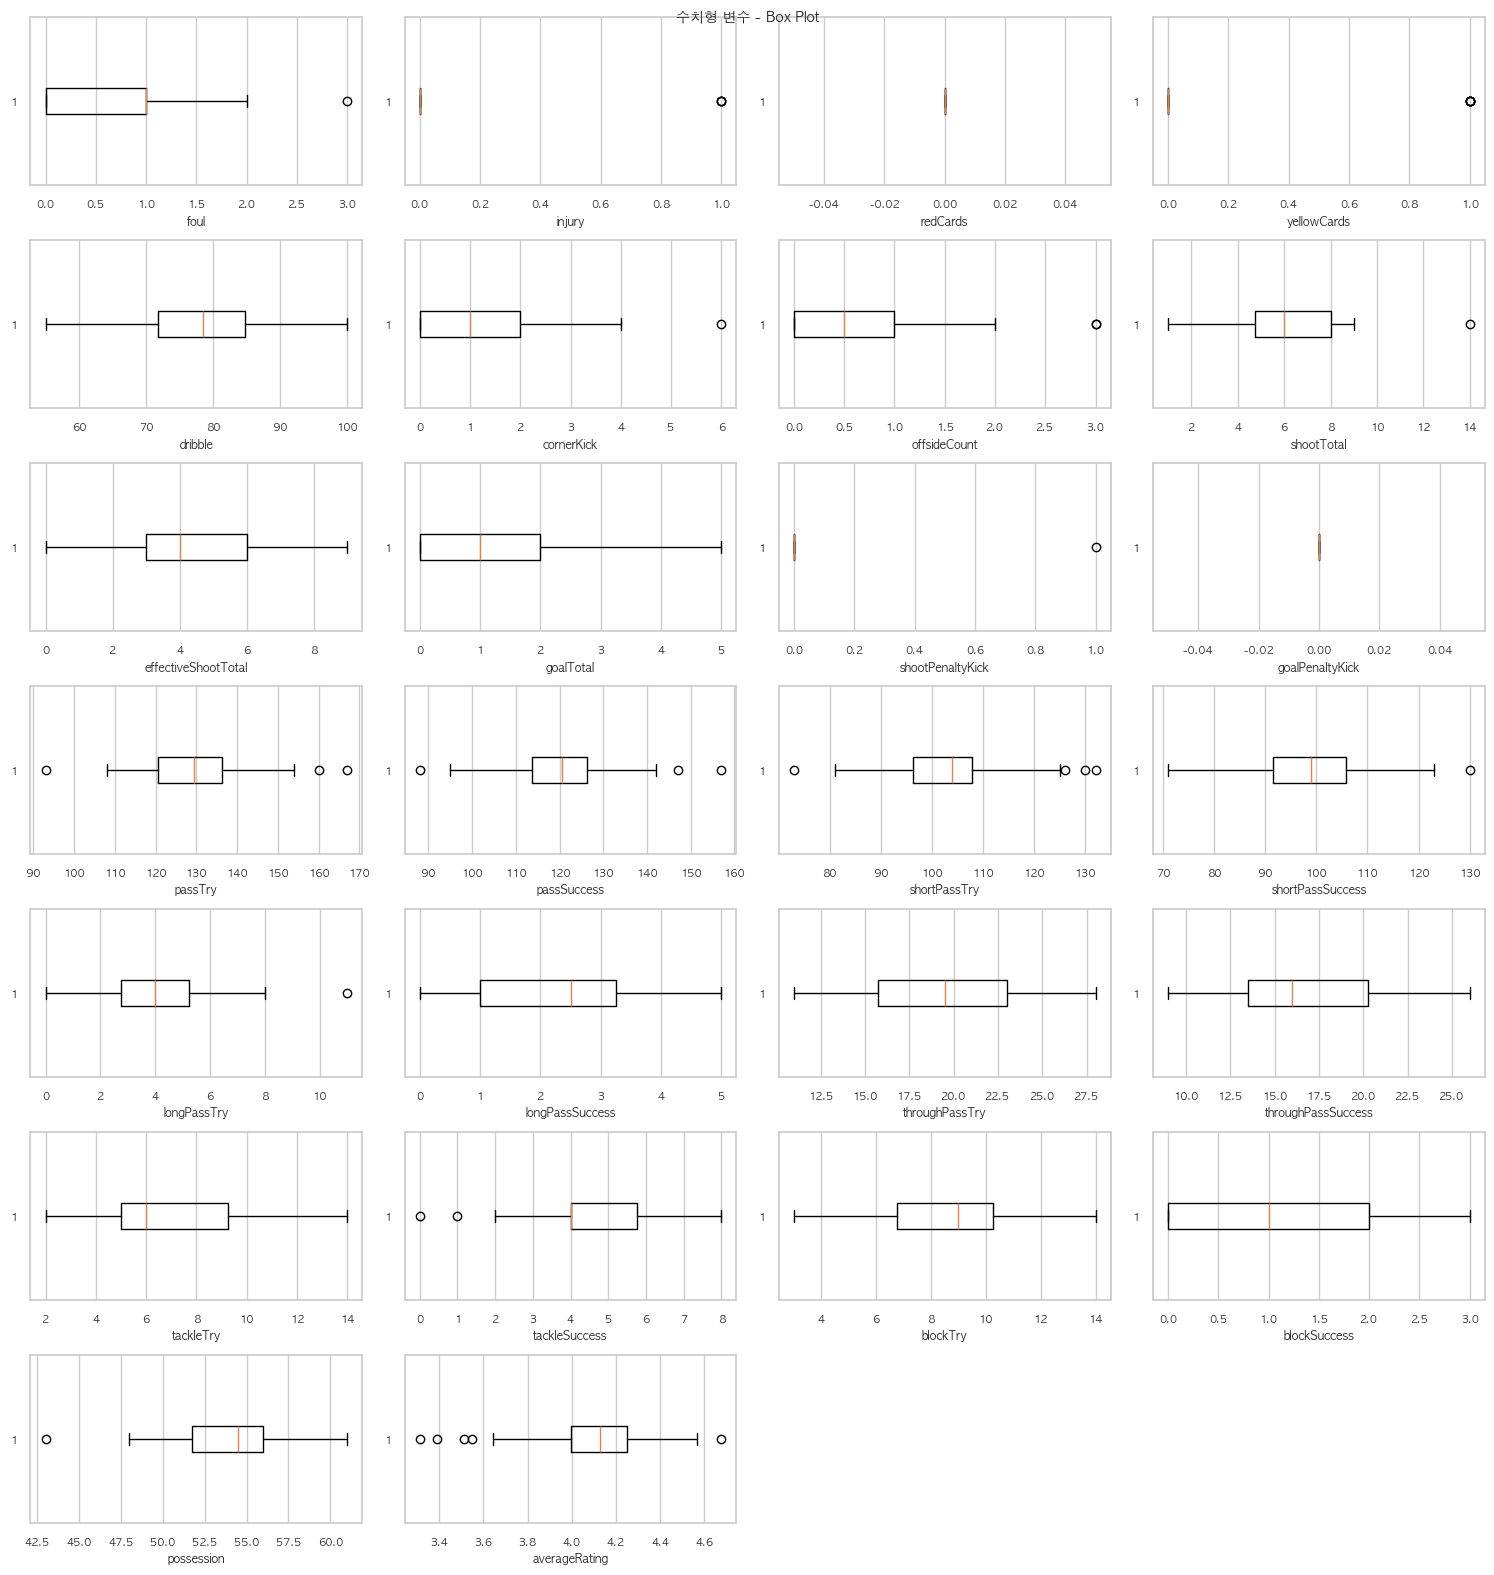

In [186]:
# 이상치 확인할 변수 선택
outlier_cols = numeric_cols

# 컬럼별 이상치 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(10,6)}, font_scale=0.7, font='AppleGothic')

fig, axes = plt.subplots(7,4,figsize=(15, 16))
axes = axes.flatten()

for i, col in enumerate(outlier_cols):
    axes[i].boxplot(match_merge_df[col],  vert=False)
    axes[i].set_xlabel(f'{col}')
    axes[i].set_xlabel(f'{col}')
    axes[i].grid(axis='y')

# 빈 서브플롯 숨기기
for j in range(len(outlier_cols), len(axes)):
    axes[j].axis("off")

fig.suptitle('수치형 변수 - Box Plot')

fig.tight_layout()
fig.show()

In [187]:
# 이상치 개수 확인
for col in outlier_cols:
  q1 = match_merge_df[col].quantile(0.25)
  q3 = match_merge_df[col].quantile(0.75)
  iqr = q3-q1
  outlier_count = len(match_merge_df[(match_merge_df[col] < (q1 - (1.5*iqr)))|(match_merge_df[col] > (q3 + (1.5*iqr)))])

  print(f"{col} - 이상치 개수: {outlier_count}", '/', f"비율: {round((outlier_count/len(match_merge_df))*100,2)}%")

foul - 이상치 개수: 1 / 비율: 3.57%
injury - 이상치 개수: 3 / 비율: 10.71%
redCards - 이상치 개수: 0 / 비율: 0.0%
yellowCards - 이상치 개수: 5 / 비율: 17.86%
dribble - 이상치 개수: 0 / 비율: 0.0%
cornerKick - 이상치 개수: 1 / 비율: 3.57%
offsideCount - 이상치 개수: 2 / 비율: 7.14%
shootTotal - 이상치 개수: 1 / 비율: 3.57%
effectiveShootTotal - 이상치 개수: 0 / 비율: 0.0%
goalTotal - 이상치 개수: 0 / 비율: 0.0%
shootPenaltyKick - 이상치 개수: 1 / 비율: 3.57%
goalPenaltyKick - 이상치 개수: 0 / 비율: 0.0%
passTry - 이상치 개수: 3 / 비율: 10.71%
passSuccess - 이상치 개수: 3 / 비율: 10.71%
shortPassTry - 이상치 개수: 4 / 비율: 14.29%
shortPassSuccess - 이상치 개수: 1 / 비율: 3.57%
longPassTry - 이상치 개수: 1 / 비율: 3.57%
longPassSuccess - 이상치 개수: 0 / 비율: 0.0%
throughPassTry - 이상치 개수: 0 / 비율: 0.0%
throughPassSuccess - 이상치 개수: 0 / 비율: 0.0%
tackleTry - 이상치 개수: 0 / 비율: 0.0%
tackleSuccess - 이상치 개수: 2 / 비율: 7.14%
blockTry - 이상치 개수: 0 / 비율: 0.0%
blockSuccess - 이상치 개수: 0 / 비율: 0.0%
possession - 이상치 개수: 1 / 비율: 3.57%
averageRating - 이상치 개수: 5 / 비율: 17.86%


> 결론

데이터 모수가 적어 이상치가 제거되면 데이터 손실이 크며, 발생한 이상치가 집계 오류가 아닌 실제로 집계가 가능한 범주에 속하기 때문에 이상치를 삭제하지 않는다.

#### ㄴ 데이터 인코딩

In [188]:
# 데이터 프레임 복제
encoded_2_df = match_merge_df.copy()
encoded_2_df.head()

,matchId,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,...,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchDate,matchResult
0,67dd625e1c27c154b533a0aa,56f931578b228109e8e44599da41ea64,1.0,0.0,0.0,1.0,82.0,2.0,0.0,9.0,...,18.0,16.0,3.0,1.0,11.0,2.0,57.0,4.20556,2025-03-21T13:08:27,무
1,67dd650053e5e88154781b92,56f931578b228109e8e44599da41ea64,3.0,1.0,0.0,1.0,71.0,3.0,1.0,5.0,...,13.0,12.0,10.0,8.0,10.0,3.0,48.0,3.99444,2025-03-21T13:20:15,패
2,67dd67a24be0a1e397cec6dd,56f931578b228109e8e44599da41ea64,1.0,0.0,0.0,0.0,81.0,4.0,0.0,7.0,...,16.0,14.0,5.0,4.0,9.0,1.0,55.0,4.15000,2025-03-21T13:31:18,무
3,67dd6a476fb2bd6b95c4b63d,56f931578b228109e8e44599da41ea64,2.0,0.0,0.0,0.0,81.0,0.0,1.0,2.0,...,15.0,12.0,10.0,8.0,10.0,1.0,56.0,3.64444,2025-03-21T13:41:54,패
4,67dd6cc0632b415e80a9d58d,56f931578b228109e8e44599da41ea64,0.0,0.0,0.0,0.0,88.0,0.0,2.0,6.0,...,13.0,12.0,6.0,5.0,8.0,0.0,57.0,4.11667,2025-03-21T13:52:50,무


In [189]:
# datetime 형식으로 변환
encoded_2_df['matchDate'] = pd.to_datetime(encoded_2_df['matchDate'])

# 평일/주말
encoded_2_df['weekend'] = encoded_2_df['matchDate'].dt.weekday.map(lambda x: '평일' if x < 5 else '주말')

# 요일
encoded_2_df['weekday'] = encoded_2_df['matchDate'].dt.day_name()

# matchDate 삭제
encoded_2_df = encoded_2_df.drop(columns='matchDate')

# 데이터 확인
print(encoded_2_df.shape)
encoded_2_df.head()

(28, 31)


,matchId,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,...,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchResult,weekend,weekday
0,67dd625e1c27c154b533a0aa,56f931578b228109e8e44599da41ea64,1.0,0.0,0.0,1.0,82.0,2.0,0.0,9.0,...,16.0,3.0,1.0,11.0,2.0,57.0,4.20556,무,평일,Friday
1,67dd650053e5e88154781b92,56f931578b228109e8e44599da41ea64,3.0,1.0,0.0,1.0,71.0,3.0,1.0,5.0,...,12.0,10.0,8.0,10.0,3.0,48.0,3.99444,패,평일,Friday
2,67dd67a24be0a1e397cec6dd,56f931578b228109e8e44599da41ea64,1.0,0.0,0.0,0.0,81.0,4.0,0.0,7.0,...,14.0,5.0,4.0,9.0,1.0,55.0,4.15000,무,평일,Friday
3,67dd6a476fb2bd6b95c4b63d,56f931578b228109e8e44599da41ea64,2.0,0.0,0.0,0.0,81.0,0.0,1.0,2.0,...,12.0,10.0,8.0,10.0,1.0,56.0,3.64444,패,평일,Friday
4,67dd6cc0632b415e80a9d58d,56f931578b228109e8e44599da41ea64,0.0,0.0,0.0,0.0,88.0,0.0,2.0,6.0,...,12.0,6.0,5.0,8.0,0.0,57.0,4.11667,무,평일,Friday


---

## EDA

<주요 변수>
- 스루패스 성공, 시도

- 짧은 패스 성공, 시도
- 패스 성공, 시도
- 유효슛
- 롱패스 성공
- 블록성공

### 1. 스루패스

#### 1) 경기 결과별 평균 스루패스 데이터
- 스루패스 시도, 성공, 성공률

##### ㄴ 다른 유저

In [206]:
# 스루패스 관련 임시 데이터 프레임 가공
throughPass_df = encoded_df.groupby(['matchId', 'ouid', 'matchResult'])[['throughPassTry', 'throughPassSuccess']].sum().reset_index()
throughPass_df.head(3)

,matchId,ouid,matchResult,throughPassTry,throughPassSuccess
0,67e5ab6c26956677381da20f,00bb68e0fa9a9f7cb1665b32dd8069b7,패,16.0,16.0
1,67e5ab6c26956677381da20f,b732daf0b96fc9256262fb36cb72c1bc,승,26.0,25.0
2,67e5ab6d0b020281e49f1496,7fe7ffb96f2154e14825d674841ff270,승,19.0,17.0


In [207]:
# 스루패스 시도
throughPass_tmp_df = throughPass_df.groupby('matchResult')[['throughPassTry','throughPassSuccess']].mean().reset_index()
throughPass_tmp_df

,matchResult,throughPassTry,throughPassSuccess
0,무,21.017544,17.807018
1,승,21.609442,18.669528
2,패,20.745690,17.258621


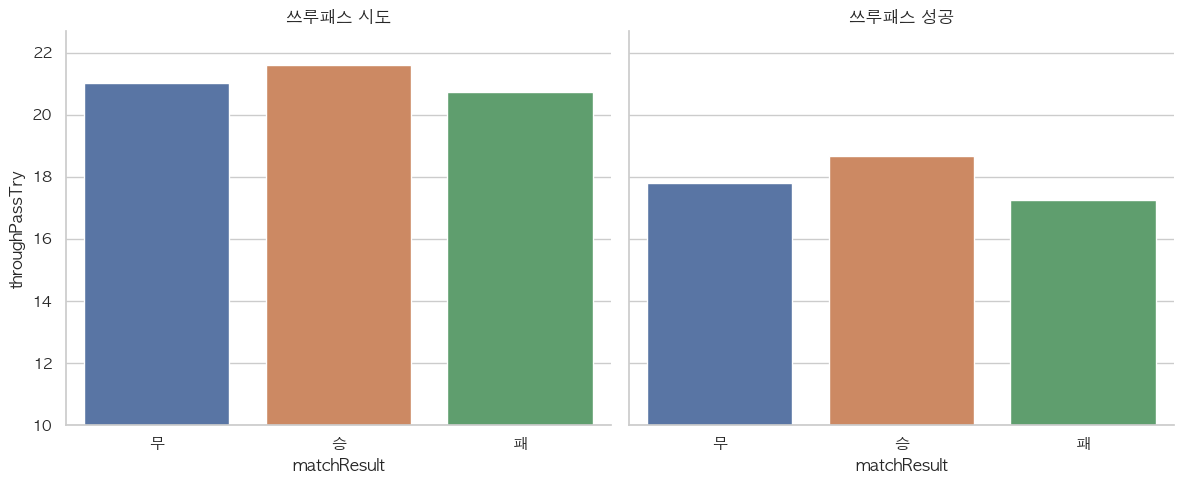

In [208]:
# 시각화
# 스타일 설정
sns.set_theme(style='whitegrid', font='AppleGothic')

# 서브플롯 생성 (가로 배치)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# 첫 번째 subplot - 시도
sns.barplot(data=throughPass_tmp_df, x='matchResult', y='throughPassTry', hue='matchResult', ax=axes[0])
axes[0].set_title('쓰루패스 시도')

# 두 번째 subplot - 성공
sns.barplot(data=throughPass_tmp_df, x='matchResult', y='throughPassSuccess', hue='matchResult', ax=axes[1])
axes[1].set_title('쓰루패스 성공')

# 추가 스타일 조정
sns.despine()
plt.ylim(10)
plt.tight_layout()
plt.show()

##### ㄴ 나

In [209]:
# 스루패스 관련 임시 데이터 프레임 가공
throughPass_2_df = encoded_2_df.groupby(['matchId', 'ouid', 'matchResult'])[['throughPassTry', 'throughPassSuccess']].sum().reset_index()
throughPass_2_df.head(3)

,matchId,ouid,matchResult,throughPassTry,throughPassSuccess
0,67dd625e1c27c154b533a0aa,56f931578b228109e8e44599da41ea64,무,18.0,16.0
1,67dd650053e5e88154781b92,56f931578b228109e8e44599da41ea64,패,13.0,12.0
2,67dd67a24be0a1e397cec6dd,56f931578b228109e8e44599da41ea64,무,16.0,14.0


In [210]:
# 스루패스 시도
throughPass_tmp_2_df = throughPass_2_df.groupby('matchResult')[['throughPassTry','throughPassSuccess']].mean().reset_index()
throughPass_tmp_2_df

,matchResult,throughPassTry,throughPassSuccess
0,무,18.222222,15.333333
1,승,20.750000,18.875000
2,패,18.909091,16.181818


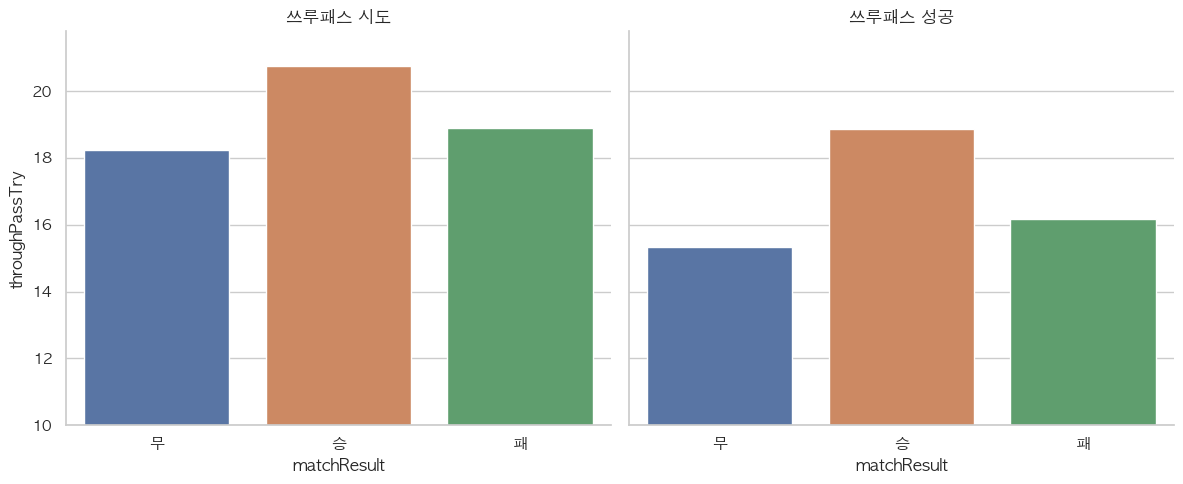

In [212]:
# 시각화
# 스타일 설정
sns.set_theme(style='whitegrid', font='AppleGothic')

# 서브플롯 생성 (가로 배치)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# 첫 번째 subplot - 시도
sns.barplot(data=throughPass_tmp_2_df, x='matchResult', y='throughPassTry', hue='matchResult', ax=axes[0])
axes[0].set_title('쓰루패스 시도')

# 두 번째 subplot - 성공
sns.barplot(data=throughPass_tmp_2_df, x='matchResult', y='throughPassSuccess', hue='matchResult', ax=axes[1])
axes[1].set_title('쓰루패스 성공')

# 추가 스타일 조정
sns.despine()
plt.ylim(10)
plt.tight_layout()
plt.show()

#### 2) 승리 경기 평균 스루패스 성공률

##### ㄴ 다른 유저

In [214]:
tmp = throughPass_tmp_df
tmp['success_rate'] = tmp['throughPassSuccess']/tmp['throughPassTry']
tmp

,matchResult,throughPassTry,throughPassSuccess,success_rate
0,무,21.017544,17.807018,0.847245
1,승,21.609442,18.669528,0.863952
2,패,20.745690,17.258621,0.831914


##### ㄴ 나

In [254]:
tmp = throughPass_tmp_2_df
tmp['success_rate'] = tmp['throughPassSuccess']/tmp['throughPassTry']
tmp

,matchResult,throughPassTry,throughPassSuccess,success_rate
0,무,18.222222,15.333333,0.841463
1,승,20.750000,18.875000,0.909639
2,패,18.909091,16.181818,0.855769


In [ ]:
# 전체 평균 데이터
success_rate = sum(throughPass_2_df['throughPassSuccess']) / sum(throughPass_2_df['throughPassTry'])
mean_avg_try = throughPass_2_df['throughPassTry'].mean()
mean_avg_success = throughPass_2_df['throughPassSuccess'].mean()
print(f"스루패스 성공률: {round(success_rate,5)}")
print(f"스루패스 평균 시도 수: {round(mean_avg_try,4)}")
print(f"스루패스 평균 성공 수: {round(mean_avg_success,4)}")


스루패스 성공률: 0.86803
스루패스 평균 시도 수: 19.2143
스루패스 평균 성공 수: 16.6786


> 결론

- 승리한 유저의 평균 스루패스 시도, 성공, 성공률이 비기고 패한 유저보다 높다.
- 스루패스 성공률은 승리한 유저 대비 내가 더 높지만, 평균 시도 횟수가 20% 적음
- 따라서 스루패스를 더 많이 시도해야 한다.

### 2. 짧은패스

#### 1) 경기 결과별 평균 짧은 패스 데이터
- 짧은 패스 시도, 성공, 성공률

##### ㄴ 다른 유저

In [231]:
# 짧은패스 관련 임시 데이터 프레임 가공
shortPass_df = encoded_df.groupby(['matchId', 'ouid', 'matchResult'])[['shortPassTry', 'shortPassSuccess']].sum().reset_index()
shortPass_df.head(3)

,matchId,ouid,matchResult,shortPassTry,shortPassSuccess
0,67e5ab6c26956677381da20f,00bb68e0fa9a9f7cb1665b32dd8069b7,패,80.0,71.0
1,67e5ab6c26956677381da20f,b732daf0b96fc9256262fb36cb72c1bc,승,59.0,56.0
2,67e5ab6d0b020281e49f1496,7fe7ffb96f2154e14825d674841ff270,승,67.0,66.0


In [ ]:
# 짧은패스 시도
shortPass_tmp_df = shortPass_df.groupby('matchResult')[['shortPassTry','shortPassSuccess']].mean().reset_index()
shortPass_tmp_df

,matchResult,shortPassTry,shortPassSuccess
0,무,71.228070,67.228070
1,승,73.133047,69.446352
2,패,73.120690,68.594828


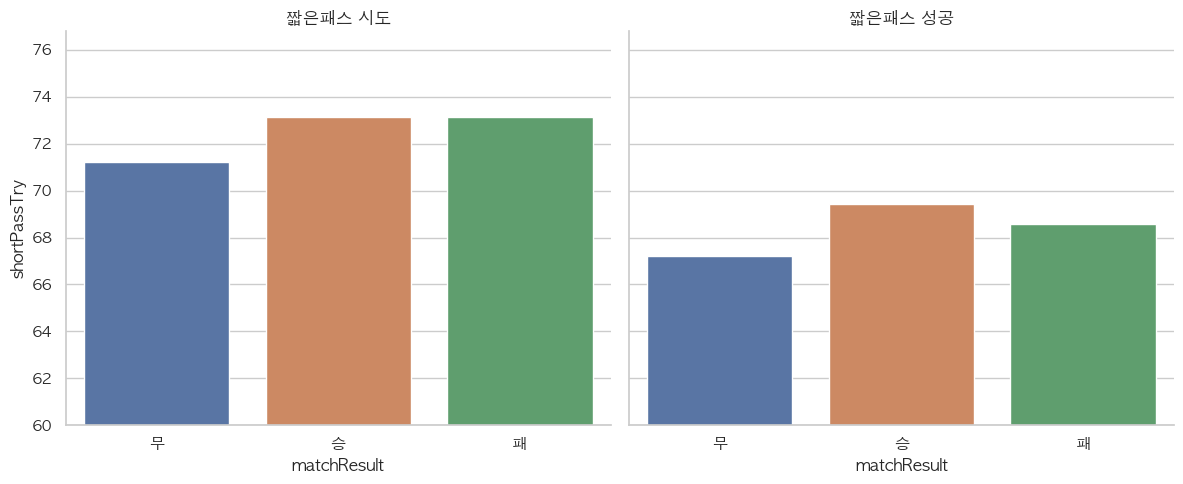

In [234]:
# 시각화
# 스타일 설정
sns.set_theme(style='whitegrid', font='AppleGothic')

# 서브플롯 생성 (가로 배치)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# 첫 번째 subplot - 시도
sns.barplot(data=shortPass_tmp_df, x='matchResult', y='shortPassTry', hue='matchResult', ax=axes[0])
axes[0].set_title('짧은패스 시도')

# 두 번째 subplot - 성공
sns.barplot(data=shortPass_tmp_df, x='matchResult', y='shortPassSuccess', hue='matchResult', ax=axes[1])
axes[1].set_title('짧은패스 성공')

# 추가 스타일 조정
sns.despine()
plt.ylim(60)
plt.tight_layout()
plt.show()

##### ㄴ 나

In [235]:
# 스루패스 관련 임시 데이터 프레임 가공
shortPass_2_df = encoded_2_df.groupby(['matchId', 'ouid', 'matchResult'])[['shortPassTry', 'shortPassSuccess']].sum().reset_index()
shortPass_2_df.head(3)

,matchId,ouid,matchResult,shortPassTry,shortPassSuccess
0,67dd625e1c27c154b533a0aa,56f931578b228109e8e44599da41ea64,무,81.0,75.0
1,67dd650053e5e88154781b92,56f931578b228109e8e44599da41ea64,패,73.0,71.0
2,67dd67a24be0a1e397cec6dd,56f931578b228109e8e44599da41ea64,무,99.0,94.0


In [236]:
# 스루패스 시도
shortPass_tmp_2_df = shortPass_2_df.groupby('matchResult')[['shortPassTry','shortPassSuccess']].mean().reset_index()
shortPass_tmp_2_df

,matchResult,shortPassTry,shortPassSuccess
0,무,99.222222,94.666667
1,승,104.250000,99.875000
2,패,107.272727,102.181818


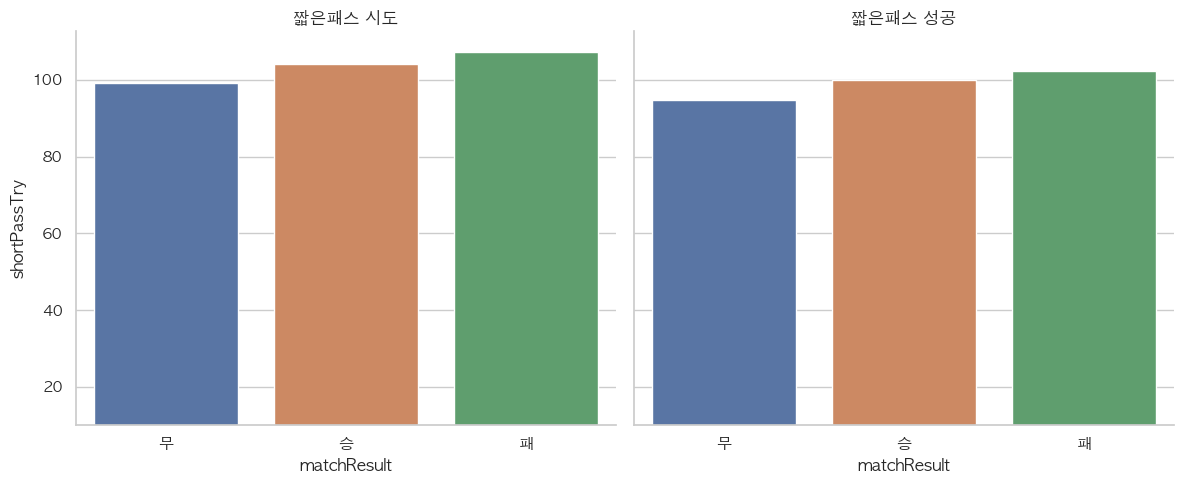

In [245]:
# 시각화
# 스타일 설정
sns.set_theme(style='whitegrid', font='AppleGothic')

# 서브플롯 생성 (가로 배치)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# 첫 번째 subplot - 시도
sns.barplot(data=shortPass_tmp_2_df, x='matchResult', y='shortPassTry', hue='matchResult', ax=axes[0])
axes[0].set_title('짧은패스 시도')

# 두 번째 subplot - 성공
sns.barplot(data=shortPass_tmp_2_df, x='matchResult', y='shortPassSuccess', hue='matchResult', ax=axes[1])
axes[1].set_title('짧은패스 성공')

# 추가 스타일 조정
sns.despine()
plt.ylim(10)
plt.tight_layout()
plt.show()

#### 2) 승리 경기 평균 짧은 패스 성공률

##### ㄴ 다른 유저

In [251]:
tmp = shortPass_tmp_df
tmp['success_rate'] = tmp['shortPassSuccess']/tmp['shortPassTry']
tmp

,matchResult,shortPassTry,shortPassSuccess,success_rate
0,무,71.228070,67.228070,0.943842
1,승,73.133047,69.446352,0.949589
2,패,73.120690,68.594828,0.938104


##### ㄴ 나

In [252]:
tmp = shortPass_tmp_2_df # [shortPass_tmp_df['matchResult'] == '승']
tmp['success_rate'] = tmp['shortPassSuccess']/tmp['shortPassTry']
tmp

,matchResult,shortPassTry,shortPassSuccess,success_rate
0,무,99.222222,94.666667,0.954087
1,승,104.250000,99.875000,0.958034
2,패,107.272727,102.181818,0.952542


In [257]:
# 전체 평균 데이터
success_rate = sum(shortPass_tmp_2_df['shortPassSuccess']) / sum(shortPass_tmp_2_df['shortPassTry'])
mean_avg_try = shortPass_tmp_2_df['shortPassTry'].mean()
mean_avg_success = shortPass_tmp_2_df['shortPassSuccess'].mean()
print(f"짧은패스 성공률: {round(success_rate,5)}")
print(f"짧은패스 평균 시도 수: {round(mean_avg_try,4)}")
print(f"짧은패스 평균 성공 수: {round(mean_avg_success,4)}")


짧은패스 성공률: 0.95488
짧은패스 평균 시도 수: 103.5816
짧은패스 평균 성공 수: 98.9078


> 결론

1. 나는 짧은 패스를 잘하지만, 이것만으로 승리는 어렵다.
	- 패한 경기에서도 짧은 패스 성공률은 매우 높았음
    - 승리한 유저들의 짧은 패스 수치는 크게 높지 않음 → “짧은 패스 수”가 승리의 직접 요인은 아닐 수 있음

2. 패스 이후의 연결(슈팅, 공간 창출 등)이 중요할 수 있다.
    - 짧은 패스는 빌드업의 한 수단일 뿐이고, 그 이후 단계가 부족했을 가능성
    - 유효 슛, 스루패스 성공 등과의 연계를 함께 분석해볼 필요 존재

3. 과도한 짧은 패스는 오히려 템포를 느리게 할 수 있다.
    - 패한 경기에서도 패스 수치가 더 높다.
    - 승리자보다 지나치게 많은 짧은 패스를 시도 → 공격 전개 속도가 느려지거나 턴오버, 태클 등으로 공 소유권이 넘어 갈 수 있음
    - 공격 전개 속도 저하 → 수비에게 정비 시간 제공 → 슛 찬스 질 저하

#### 3) 짧은 패스 수와 유효슛 수의 관계 분석

##### ㄴ 다른 유저

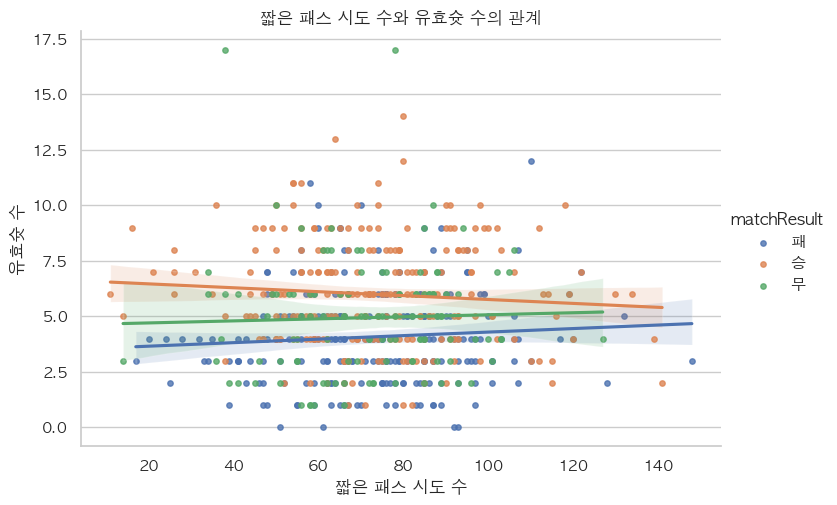

짧은 패스 시도와 유효슛 수의 상관계수: 0.0004


In [269]:
# 산점도 및 회귀선 그리기
sns.lmplot(data=encoded_df, x='shortPassTry', y='effectiveShootTotal', hue='matchResult', aspect=1.5,scatter_kws={'s': 15})
plt.title('짧은 패스 시도 수와 유효슛 수의 관계')
plt.xlabel('짧은 패스 시도 수')
plt.ylabel('유효슛 수')
sns.despine()
plt.grid(axis='x')
plt.show()

# 상관계수 계산
correlation = encoded_df[['shortPassTry', 'effectiveShootTotal']].corr().iloc[0,1]
print(f"짧은 패스 시도와 유효슛 수의 상관계수: {correlation:.4f}")

##### ㄴ 나

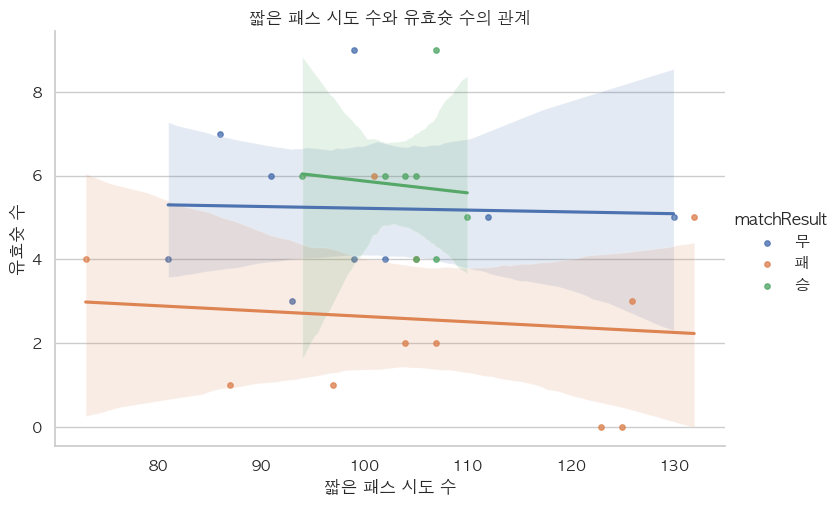

짧은 패스 시도와 유효슛 수의 상관계수: -0.1725


In [271]:
# 산점도 및 회귀선 그리기
sns.lmplot(data=encoded_2_df, x='shortPassTry', y='effectiveShootTotal', hue='matchResult', aspect=1.5,scatter_kws={'s': 15})
plt.title('짧은 패스 시도 수와 유효슛 수의 관계')
plt.xlabel('짧은 패스 시도 수')
plt.ylabel('유효슛 수')
sns.despine()
plt.grid(axis='x')
plt.show()

# 상관계수 계산
correlation = encoded_2_df[['shortPassTry', 'effectiveShootTotal']].corr().iloc[0,1]
print(f"짧은 패스 시도와 유효슛 수의 상관계수: {correlation:.4f}")

> 결론

1. 다른 유저들은 짧은 패스와 유효슛이 미세하지만 양의 상관관계를 보이고 있고, 특히 승리한 유저는 확연한 양의 상관관계, 패배한 유저는 확연한 음의 상관관계가 관찰된다.

2. 반면 나는 모든 결과에서 음의 상관관계가 관찰된다. 즉 짧은 패스를 선호하고 많이 하는 플레이 스타일을 갖고 있지만 이 짧은 패스가 유효슛으로 잘 이어지지 않는다.

#### 4) 짧은 패스 후 전진 패스 비율 계산
- 공격 템포 지표 정의 : 짧은패스 당 전진패스(스루패스, 롱패스)
    - 공격 템포 = (스루패스 성공 + 롱패스 성공) / 짧은패스 성공
- 짧은 패스를 한 후 전진하는 스루패스/롱패스가 얼마나 이어지는지 비율로 측정

##### ㄴ 다른 유저

  matchResult  attackTempo
0           무     0.368156
1           승     0.393296
2           패     0.348990


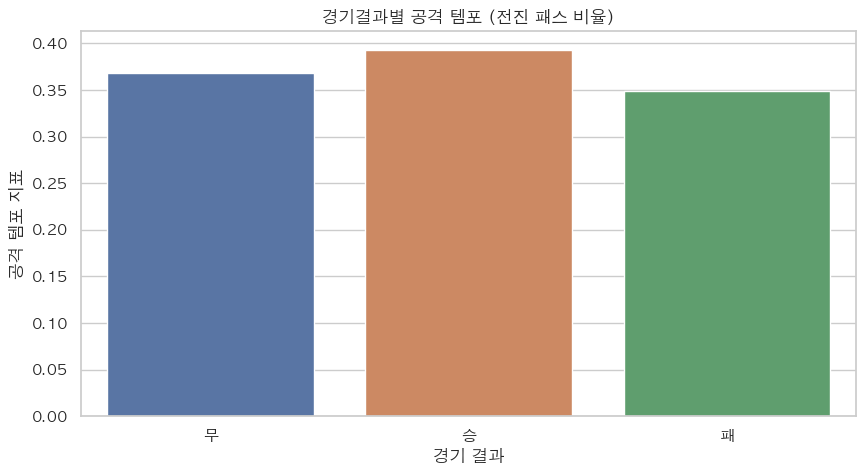

In [274]:
tmp_df = encoded_df.copy()
# 공격 템포 지표 생성
tmp_df['attackTempo'] = (tmp_df['throughPassSuccess'] + tmp_df['longPassSuccess']) / tmp_df['shortPassSuccess']

# 경기 결과별 평균 템포 비교
tempo_by_result = tmp_df.groupby('matchResult')['attackTempo'].mean().reset_index()
print(tempo_by_result)

# 시각화
sns.barplot(data=tempo_by_result, x='matchResult', y='attackTempo', hue='matchResult')
plt.title('경기결과별 공격 템포 (전진 패스 비율)')
plt.xlabel('경기 결과')
plt.ylabel('공격 템포 지표')
plt.show()

##### ㄴ 나

  matchResult  attackTempo
0           무     0.197390
1           승     0.211675
2           패     0.181628


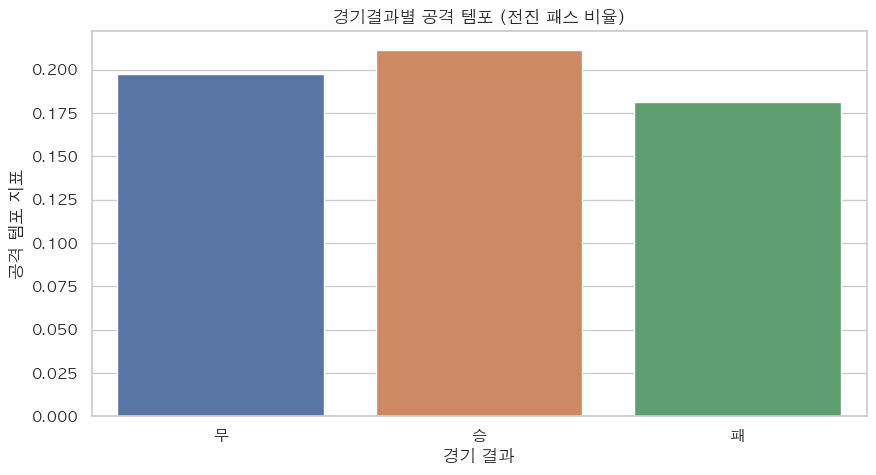

In [275]:
tmp_df = encoded_2_df.copy()
# 공격 템포 지표 생성
tmp_df['attackTempo'] = (tmp_df['throughPassSuccess'] + tmp_df['longPassSuccess']) / tmp_df['shortPassSuccess']

# 경기 결과별 평균 템포 비교
tempo_by_result = tmp_df.groupby('matchResult')['attackTempo'].mean().reset_index()
print(tempo_by_result)

# 시각화
sns.barplot(data=tempo_by_result, x='matchResult', y='attackTempo', hue='matchResult')
plt.title('경기결과별 공격 템포 (전진 패스 비율)')
plt.xlabel('경기 결과')
plt.ylabel('공격 템포 지표')
plt.show()

> 결론

1. 승리하는 경기에서 공격 템포(짧은 패스 당 전진패스)가 높다. - 공격 템포가 승리에 유의미히디.

2. 다른 유저들은 짧은 패스 후 전진 패스가 비교적 활발하다. (공격 템포가 좋음)

3. 나는 짧은 패스 후 전진 패스가 비교적 활발하지 않다. (공격 템포가 나쁨) 다른 유저에 비해 약 2배정도 차이남